# Download GNSS data

## Tools

*Modules*

In [1]:
import numpy as np
import numpy.random as rd
import math as m
import pandas as pd
import warnings
import json
from astropy.time import Time

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.cm as cmx
import matplotlib.ticker as ti
from matplotlib import patheffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.legend_handler import HandlerTuple
from fontTools.ttLib import TTFont
from matplotlib.font_manager import fontManager, FontProperties
from adjustText import adjust_text
import seaborn as sns
import cmcrameri.cm as cmc

import geopandas as gpd
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cf
import pygmt
from pygmt.datasets import load_earth_relief
import fiona
from shapely.geometry import shape
import cartopy.io.shapereader as shapereader
from osgeo import gdal, osr
from cartopy.io.srtm import add_shading

In [2]:
plt.style.use('myfig.mplstyle')

*Paths*

In [3]:
# paths
wkdir = "/Users/emile/Documents/Etude/2024_2025_M2/tutored_project"
datadir = "{:}/data".format(wkdir)
plotdir = "{:}/figures".format(wkdir)

*Import Dead Sea levels data*

In [4]:
# Dead sea level (1976 - 2024)
# Data provided by the Hydrological Service of the Government Water and Sewage Authority, Israel
# (Gauge near Massada)

with open("{:}/Dead_Sea_level/Dead_Sea_level_1976_2024.json".format(datadir)) as f:
    dead_sea_level_1976_2024 = json.load(f)

dead_sea_level_1976_2024 = pd.DataFrame(dead_sea_level_1976_2024['result']['records'])
dead_sea_level_1976_2024["date"] = pd.to_datetime(dead_sea_level_1976_2024["תאריך מדידה"], format="%d/%m/%Y")
dead_sea_level_1976_2024["date_yr"] = [Time(t, format='datetime').decimalyear for t in dead_sea_level_1976_2024["date"]]
dead_sea_level_1976_2024["sea_level"] = dead_sea_level_1976_2024["מפלס"].astype('float64')
dead_sea_level_1976_2024 = dead_sea_level_1976_2024.drop(labels=['_id', 'תאריך מדידה', 'מפלס'], axis=1)
dead_sea_level_1976_2024.sort_values('date', inplace=True)
dead_sea_level_1976_2024.reset_index(drop=True, inplace=True)

In [5]:
# Dea Sea level (1900 - 2005)
# Bookman et al., 2006, Quaternary lake levels in the Dead Sea basin: Two centuries of research
# Rock benchmark, gauges (Palestine Potash Companies and Dead Sea Works Ltd.)

dead_sea_level_1900_2005 = pd.read_csv("{:}/Dead_Sea_level/Dead_Sea_level_1900_2000.csv".format(datadir),
                                       names=['date_yr', 'sea_level'], sep=';')
dead_sea_level_1900_2005 = dead_sea_level_1900_2005.sort_values('date_yr').reset_index(drop=True)
dead_sea_level_1900_2005 = dead_sea_level_1900_2005[dead_sea_level_1900_2005.date_yr >= 1900].reset_index(drop=True)
dead_sea_level_1900_2005 = dead_sea_level_1900_2005[dead_sea_level_1900_2005.date_yr <= dead_sea_level_1976_2024.date_yr[0]].reset_index(drop=True)
dead_sea_level_1900_2005.sea_level = - dead_sea_level_1900_2005.sea_level
dead_sea_level_1900_2005['date'] = [Time(t, format='decimalyear').datetime.replace(hour=0, minute=0, second=0, microsecond=0) for t in dead_sea_level_1900_2005.date_yr]
dead_sea_level_1900_2005 = dead_sea_level_1900_2005[['date', 'date_yr', 'sea_level']]

/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/emile/anaconda3/envs/pygdal/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarn

## Merge data

In [6]:
dead_sea_level_1900_2005.sea_level -= dead_sea_level_1900_2005.sea_level.values[-1]
dead_sea_level_1900_2005.sea_level += dead_sea_level_1976_2024.sea_level[0]

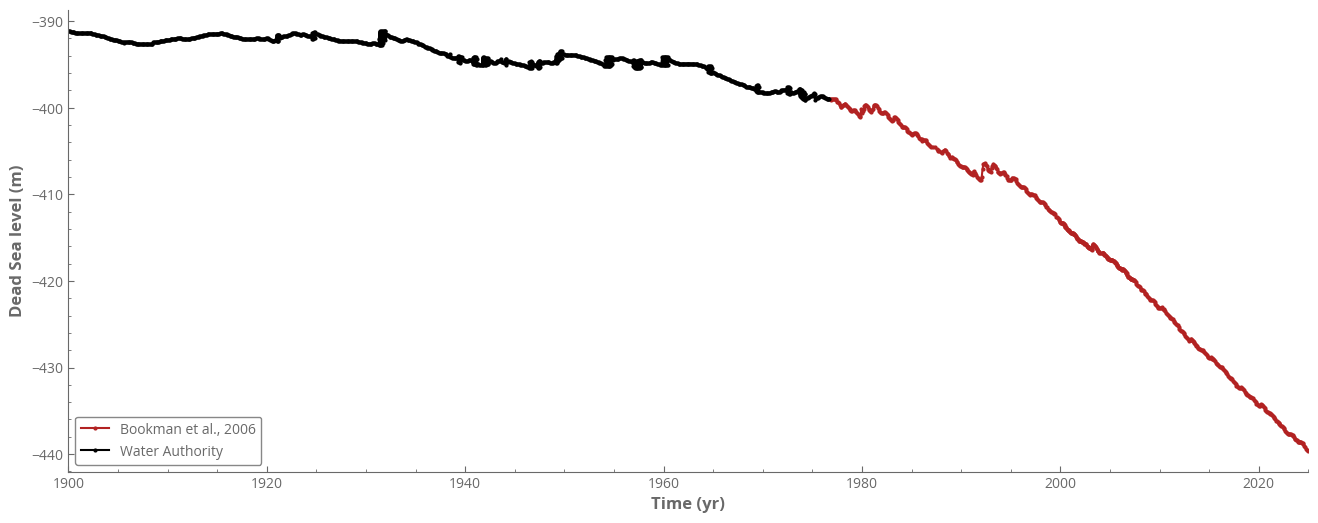

In [7]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(dead_sea_level_1976_2024.date_yr, dead_sea_level_1976_2024.sea_level, '-o', c='firebrick', label='Bookman et al., 2006', markersize=2)
ax.plot(dead_sea_level_1900_2005.date_yr, dead_sea_level_1900_2005.sea_level, '-o', c='k', label='Water Authority', markersize=2)

ax.set_xlabel('Time (yr)')
ax.set_ylabel('Dead Sea level (m)')

ax.set_xlim(1900, 2025)

ax.legend(loc='lower left')

plt.show()

In [8]:
dead_sea_level = pd.merge(dead_sea_level_1900_2005, dead_sea_level_1976_2024, how='outer')

In [9]:
dead_sea_level.to_csv("{:}/Dead_Sea_level/Dead_Sea_level.csv".format(datadir), index=False)